Copyright (c) 2021-2023, NVIDIA CORPORATION & AFFILIATES

SPDX-License-Identifier: BSD-3-Clause

In this notebook we will go over some examples to show how to use cuTensorNet to execute advanced quantum algorithms in Qiskit. The topics we'll cover include:
 - Create a biased sampler
 - Compute the expectation values

In [1]:
import itertools

import cupy as cp
import matplotlib.pyplot as plt
import numpy as np

from cuquantum import contract, contract_path, CircuitToEinsum
from cuquantum import cutensornet as cutn

np.random.seed(6)

# Biased Sampler

Let's first create a parameterized entangled circuit as our sampler. This can be easily achieved using the `TwoLocal` class in qiskit.

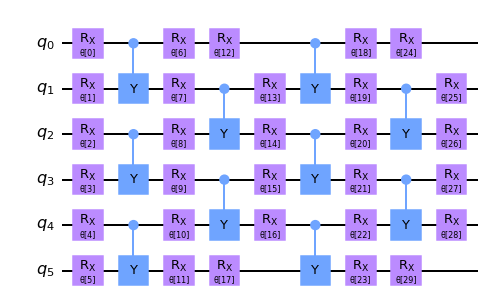

In [2]:
from qiskit.circuit.library.n_local.two_local import TwoLocal

num_qubits = 6
layer_1 = [(0, 1), (2, 3), (4, 5)]
layer_2 = [(1, 2), (3, 4)]
circuit = TwoLocal(num_qubits, 'rx', ['cy'], [layer_1, layer_2], reps=4)
circuit = circuit.decompose()
circuit.draw(output='mpl')

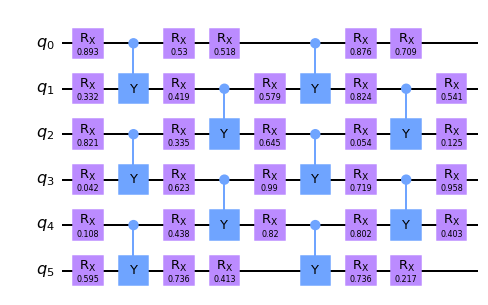

In [3]:
# bind all parameters with random numbers so that they can be parsed by the converter

n_params = len(circuit.parameters)
random_params = np.around(np.random.random(n_params), decimals=3)
params = dict(zip(circuit.parameters, random_params))

binded_circuit = circuit.bind_parameters(params)
binded_circuit.draw(output='mpl')

Now compute the marginal probabilities using the reduced density matrix of qubits 0 & 4, subject to qubit 1 being in state 0 and qubit 2 in state 1.

In [4]:
myconverter = CircuitToEinsum(binded_circuit, dtype='complex128')

qubits = binded_circuit.qubits
where = (qubits[0], qubits[4])
fixed = {qubits[1]: '0',
         qubits[2]: '1'}  # setting fixed=None will generate unbiased probablity
expression, operands = myconverter.reduced_density_matrix(where, fixed=fixed)
rdm = contract(expression, *operands)
    
n_sites = len(where)
sh = 2 ** n_sites
prob = abs(rdm.reshape(sh, sh).diagonal())**2
marginal = prob.reshape((2,)*n_sites) / prob.sum()  # normalization

print(marginal)

[[0.12157607 0.73030532]
 [0.01152332 0.13659528]]


We can now create a sampler based on the marginal probabilities.


10000 samples on (Qubit(QuantumRegister(6, 'q'), 0), Qubit(QuantumRegister(6, 'q'), 4)) assuming:
  - Qubit(QuantumRegister(6, 'q'), 1) is fixed at state 0
  - Qubit(QuantumRegister(6, 'q'), 2) is fixed at state 1


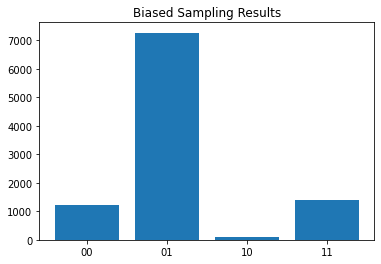

In [5]:
def create_samples(marginal, nsample):
    # this function generates samples on CPU, since we are sampling over Python strings 
    nqubits = marginal.ndim    
    bitstrings = [''.join(bitstring) for bitstring in itertools.product('01', repeat=nqubits)]
    ps = cp.asnumpy(marginal.flatten())
    return np.random.choice(bitstrings, size=nsample, p=ps)

nsample = 10000
samples = create_samples(marginal, nsample)
keys, counts = np.unique(samples, return_counts=True)

print(f'\n{nsample} samples on {where} assuming:')
for q, state in fixed.items():
    print(f'  - {q} is fixed at state {state}')

# plot the result; note the keys are already sorted by numpy.unique() 
plt.bar(keys, counts)
plt.title('Biased Sampling Results')
plt.show()

# Expectation Value Computation

In this part, we will show how to compute expectation values using a modified Max-Cut QAOA problem taken from [Qiskit Textbook](https://qiskit.org/textbook/ch-applications/qaoa.html) as an example.

We first use `networkx` to generate a random regular graph as the problem graph

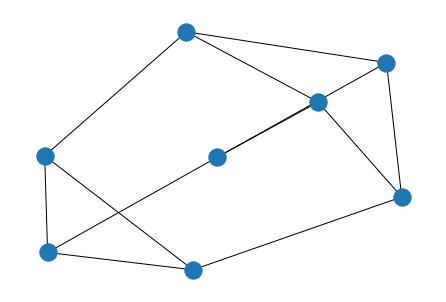

In [6]:
import networkx as nx
from qiskit import QuantumCircuit, Aer

reg = 3
n = 8
seed = 666

G = nx.random_regular_graph(reg, n, seed=seed)
weights = {(i, j): 1 for i, j in G.edges}
nx.draw(G)

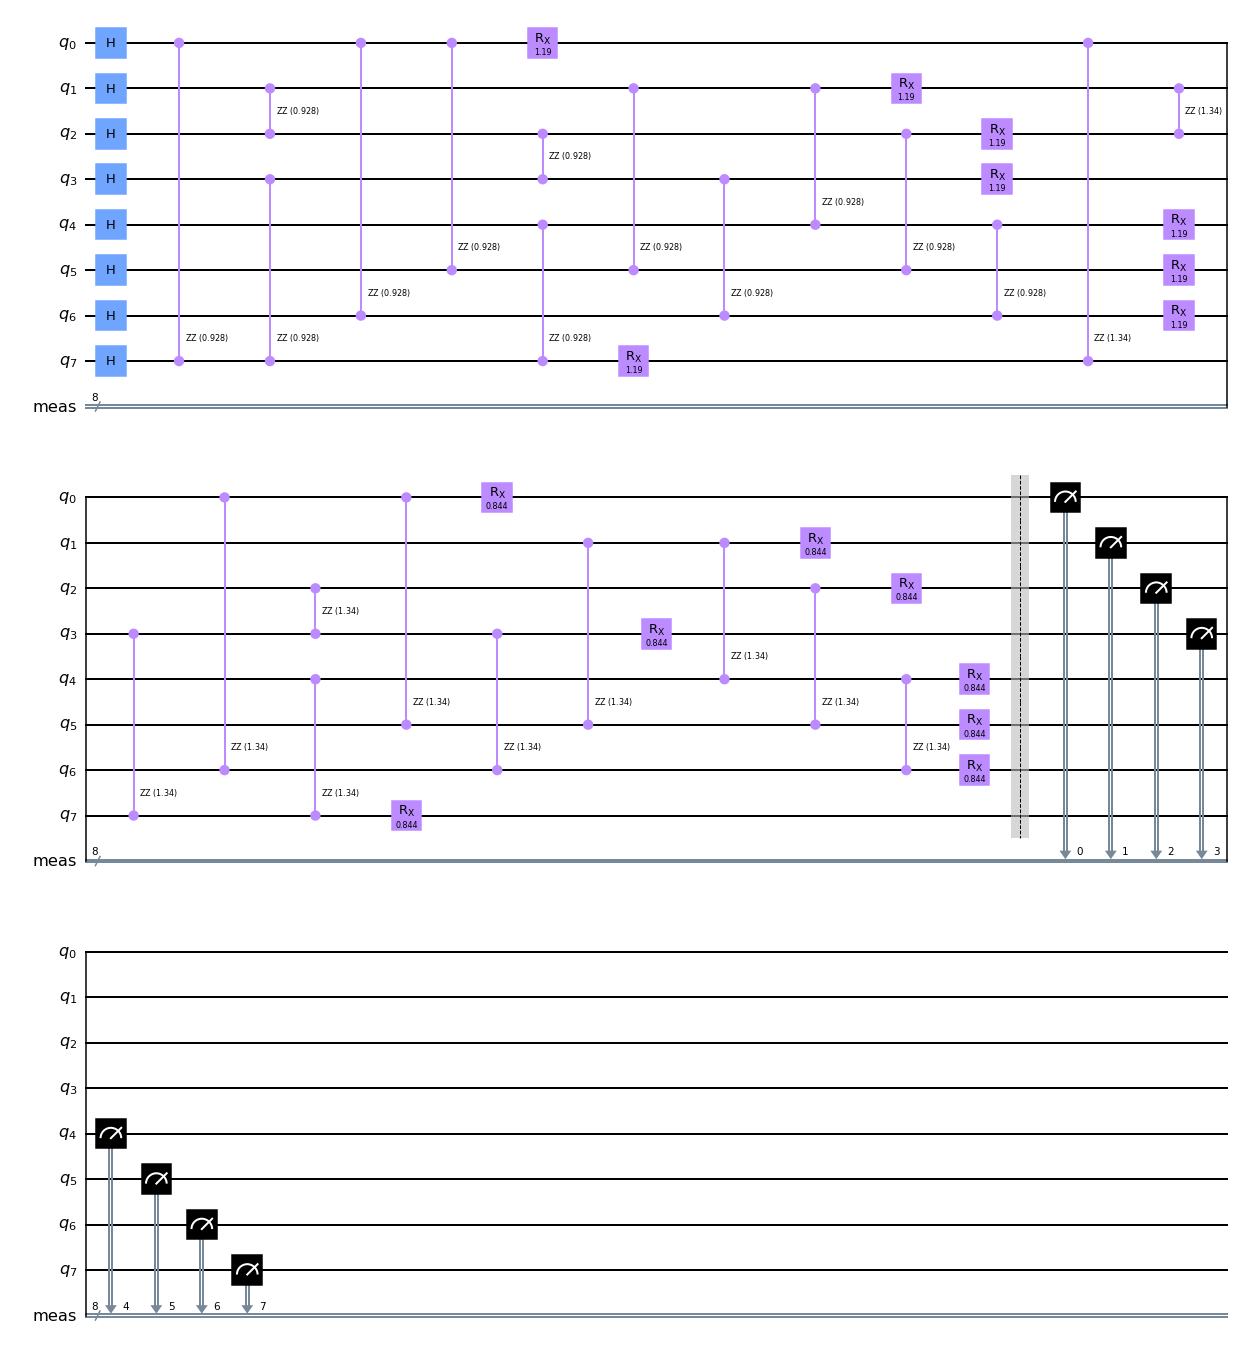

In [7]:
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
    qc.measure_all()
    return qc


p = 4  # depth
theta = np.random.random(p)
circuit = create_qaoa_circ(G, theta)
circuit.draw(output='mpl')

Construct the expectation function that returns the energy for a given parameter set. Here two expectation functions are constructed for comparsion:

  - `expectation_cutn` returns the expectation using the reduced density matrix computed with cuTensorNet
  - `expectation_qiskit` returns the expectation by sampling with Qiskit's simulator

In [8]:
def get_expectation_cutn(G, weights):
    paths = dict()  # cache paths

    def get_path(expression, operands, options, edge):
        if edge not in paths:
            out = paths[edge] = contract_path(expression, *operands, options=options)
        else:
            out = paths[edge]
        return out
    
    def expectation(theta):
        e = 0.
        
        # trick: reuse the cuTensorNet library handle to reduce overhead
        handle = cutn.create()
        options = {'handle': handle}
        
        circuit = create_qaoa_circ(G, theta)
        myconverter = CircuitToEinsum(circuit, dtype='complex128', backend=cp)
        
        for (i, j), weight in weights.items():
            pauli_string = {circuit.qubits[i]: 'Z',
                            circuit.qubits[j]: 'Z'}
            expression, operands = myconverter.expectation(pauli_string, lightcone=True)
            _, path_info = get_path(expression, operands, options, (i, j))
            e += contract(expression, *operands,
                          optimize={'path': path_info.path, 'slicing': path_info.slices},
                          options=options).real
            
            # the same task can be achieved with reduced density matrix:
            
            # where = (circuit.qubits[i], circuit.qubits[j])
            # expression, operands = myconverter.reduced_density_matrix(where, lightcone=True)
            # _, path_info = get_path(expression, operands, options, (i, j))
            # rdm = contract(expression, *operands, 
            #                optimize={'path': path_info.path, 'slicing': path_info.slices}, 
            #                options=options).real
            # Zop = cp.diag([1,-1]).astype('complex128')
            # e+= cp.einsum('ijIJ,Ii,Jj->', rdm, Zop, Zop).real
        
        # handle should be explictly destroyed
    
        cutn.destroy(handle)
        
        return e
    
    return expectation

def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
    return obj

def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results, this energy is different from the get_expectation_cutn
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

def get_expectation_qiskit(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=shots).result().get_counts()
        return compute_expectation(counts, G)
    
    return execute_circ


expectation_cutn = get_expectation_cutn(G, weights)
expectation_qiskit = get_expectation_qiskit(G, p=p, shots=10000)

use `scipy.optimize` to find the solution for the two different backends

In [9]:
from scipy.optimize import minimize

result_cutn = minimize(expectation_cutn, theta, method='COBYLA')
print(result_cutn, "\n")

result_qiskit = minimize(expectation_qiskit, theta, method='COBYLA')
print(result_qiskit)

     fun: -5.974513781450166
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 126
  status: 1
 success: True
       x: array([2.09892427, 1.27968803, 1.80457485, 1.99563031]) 

     fun: -6.4296875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 44
  status: 1
 success: True
       x: array([-0.13803829,  0.16958271,  0.98235416, -1.31578948])


Now we can analyze the results from the two backends using the internal simulator of `qiskit`

In [10]:
def get_top_results_from_theta(G, theta, n_top, shots=10000):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    qc_res = create_qaoa_circ(G, theta)
    counts = backend.run(qc_res, seed_simulator=10, shots=shots).result().get_counts()

    sols = sorted(counts.items(), key=lambda item: -item[1])[:n_top]
    return [bitstring[::-1] for bitstring, _ in sols]


n_top = 10  # find the top 10 solutions
shots = 10000
bitstrings_cutn = get_top_results_from_theta(G, result_cutn.x, n_top, shots=shots)
bitstrings_qiskit = get_top_results_from_theta(G, result_qiskit.x, n_top, shots=shots)

print(f'Top {n_top} solutions from cuTensorNet')
for bitstring in bitstrings_cutn:
    print(bitstring, maxcut_obj(bitstring, G))
    
print('\n')

print(f'Top {n_top} solutions from Qiskit')
for bitstring in bitstrings_qiskit:
    print(bitstring, maxcut_obj(bitstring, G))

Top 10 solutions from cuTensorNet
00100111 -10
10011100 -10
01100011 -10
10111000 -10
11011000 -10
01000111 -10
11100011 -9
01010111 -9
10101000 -9
00101111 -9


Top 10 solutions from Qiskit
01000111 -10
10011100 -10
00100111 -10
11011000 -10
10111000 -10
01100011 -10
10101000 -9
00011101 -8
01010111 -9
00011100 -9


In [11]:
# in this particular example, there are 6 bitstrings reaching minimum, and cuTensorNet
# and Qiskit should return the same set of best answers.
assert set(bitstrings_cutn[:6]) == set(bitstrings_qiskit[:6])